In [1]:
import os
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import utils.globals as globals

plt.rcParams.update({
    'text.usetex': True, 
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'], 
    'font.size': 14, 
})

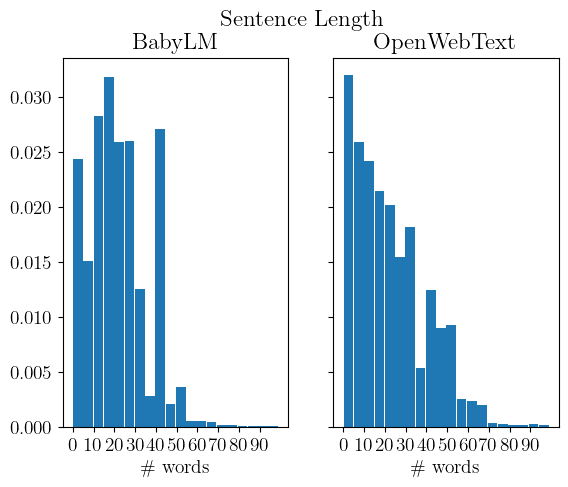

In [12]:
# Pre-experiment
# Sentence length distribution
def counts_to_list(counts, cutoff=100):
    out = []
    for key, val in counts.items():
        if int(key) > cutoff:
            continue
        for _ in range(val):
            out.append(key)
    df = pd.DataFrame({
        '# Words': out
    })
    return df

with open('../data/subsampled/sent_len_counts.json', 'r') as f:
    counts_babylm = json.load(f)
    counts_babylm = counts_to_list(counts_babylm)

with open('../data/subsampled/sent_len_counts_openwebtext_dist.json', 'r') as f:
    counts_openwebtext = json.load(f)
    counts_openwebtext = counts_to_list(counts_openwebtext)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(counts_babylm['# Words'], bins=20, rwidth=0.95, density=True)
ax2.hist(counts_openwebtext['# Words'], bins=20, rwidth=0.95, density=True)

ax1.set_xticks(ticks=np.arange(0, 100, step=10), labels=np.arange(0, 100, step=10))
ax1.set_xlabel('\# words')
ax1.set_title('BabyLM')

ax2.set_xticks(ticks=np.arange(0, 100, step=10), labels=np.arange(0, 100, step=10))
ax2.set_xlabel('\# words')
ax2.set_title('OpenWebText')

plt.suptitle('Sentence Length')

plt.savefig('./figs/sentence_length.pdf', dpi=200)

plt.show()

In [13]:
# Get a list of overall syneval accuracy
def get_syneval_total_acc(path):
    with open(path, 'r') as f:
        data = json.load(f)
    
    checkpoint_iters = sorted([int(key.split('-')[-1]) for key in data.keys()])
    checkpoint_head = '-'.join([key.split('-')[:-1] for key in data.keys()][0])
    
    accs = []
    for iter in checkpoint_iters:
        if iter == 130000:
            break
        k = f'{checkpoint_head}-{iter}'
        acc = aggregate_acc(data[k])
        accs.append(acc)

    return checkpoint_iters, accs

def aggregate_acc(data):
    total_n_test = 0
    for val in data.values():
        for v in val.values():
            # total_n_test += v[1]
            total_n_test += 1

    out = 0
    for val in data.values():
        for v in val.values():
            # out += v[0] * v[1] / total_n_test
            out += v[0] / total_n_test
    return out

# get_syneval_total_acc(f'{globals.OUT_DIR}/openwebtext-poc_syneval.json')
    

In [14]:
def get_aggregated(paths):
    ys = []
    for path in paths:
        x, y = get_syneval_total_acc(f'{globals.OUT_DIR}/{path}_syneval.json')
        ys.append(y)
    x = np.array(x)
    ys = np.array(ys)

    std = np.std(ys, axis=0)
    mean = np.mean(ys, axis=0)

    lower_bound = mean - std
    upper_bound = mean + std
    return x, mean, lower_bound, upper_bound
    
    
paths_babylm = ['babylm_100M-poc', 'babylm_100M-poc1', 'babylm_100M-poc2']
paths_openwebtext = ['openwebtext-poc', 'openwebtext-poc1', 'openwebtext-poc2']

x, m1, l1, u1 = get_aggregated(paths_babylm)
x, m2, l2, u2 = get_aggregated(paths_openwebtext)
x, m3, l1, u1 = get_aggregated(['subsample_vocab-poc2'])

x = np.array([x, x, x]).reshape(-1)
m = np.array([m1, m2, m3]).reshape(-1)
print(x.shape)
print(m.shape)

df = pd.DataFrame({
    '# Iteration': x,
    'Accurcay': m,
    'dataset': ['babyLM' for _ in range(len(x)//3)] + ['OpenWebText' for _ in range(len(x)//3)] + ['OpenWebText w/ subsampling by vocab' for _ in range(len(x)//3)]
})

ax = sns.lineplot(data = df, x = '# Iteration', y = 'Accurcay', hue = 'dataset')
plt.title('Performance on (Marvin and Linzen, 2018) \n (macro averaged across sub-categories)')
plt.savefig('./figs/syneval overall.png', dpi=200)
# ax.add_collection(plt.fill_between(x, l1, u1, alpha=.3))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [61]:
def aggregate_sub_cat(data):
    out = {}
    for d, subs in data.items():
        accs = []
        for val in subs.values():
            accs.append(val[0])
        out[d] = sum(accs) / len(accs)
    return out
path = f'{globals.OUT_DIR}/openwebtext-poc2_syneval.json'

with open(path, 'r') as f:
    data = json.load(f)['../results/model_checkpoints/openwebtext-poc2/checkpoint-40000']

out = aggregate_sub_cat(data)
for k, v in out.items():
    print(k)
    print(v)


prep_anim
0.6845833333333333
vp_coord
0.8690476190476191
simple_agrmt
0.9214285714285715
obj_rel_within_inanim
0.8202380952380953
prep_inanim
0.8337301587301587
reflexives_across
0.6604910714285714
simple_npi_anim
0.4666666666666667
obj_rel_no_comp_across_inanim
0.808829365079365
subj_rel
0.6533035714285714
obj_rel_across_anim
0.7729464285714285
reflexive_sent_comp
0.8428571428571429
obj_rel_no_comp_across_anim
0.65125
obj_rel_no_comp_within_inanim
0.8211309523809524
obj_rel_within_anim
0.7908928571428572
npi_across_anim
0.4508333333333333
simple_reflexives
0.9321428571428572
simple_npi_inanim
0.32638888888888884
obj_rel_no_comp_within_anim
0.7822321428571428
sent_comp
0.881547619047619
npi_across_inanim
0.4628472222222222
obj_rel_across_inanim
0.8844246031746033
long_vp_coord
0.8725


In [59]:
lis = [0.90,
0.79,
0.67,
0.63,
0.70,
0.79,
0.68,
0.62,
0.80,
0.75,
0.56,
0.53,
0.53,
0.00,
0.02]
print(np.average(np.array(lis)))

0.598


In [15]:

iters, acc, ds = [], [], []
dirs = ['../results/outputs/babylm_100M-poc/sva',
        '../results/outputs/babylm_100M-poc1/sva',
        '../results/outputs/babylm_100M-poc2/sva']
for dir in dirs:
    for iter in range(5000, 130000, 5000):
        path = f'{dir}/checkpoint-{iter}.csv'
        df = pd.read_csv(path)
        
        original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
        original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]

        gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
        gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]

        iters.append(iter)
        acc.append(len(original_hit)/len(original))
        ds.append('BabyLM_original')

        iters.append(iter)
        acc.append(len(gen_hit)/len(gen))
        ds.append('BabyLM_nonce')

dirs = ['../results/outputs/openwebtext-poc/sva',
       '../results/outputs/openwebtext-poc1/sva',
       '../results/outputs/openwebtext-poc2/sva']

for dir in dirs:
    for iter in range(5000, 130000, 5000):
        path = f'{dir}/checkpoint-{iter}.csv'
        df = pd.read_csv(path)
        
        original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
        original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]

        gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
        gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]

        iters.append(iter)
        acc.append(len(original_hit)/len(original))
        ds.append('OpenWebText_original')

        iters.append(iter)
        acc.append(len(gen_hit)/len(gen))
        ds.append('OpenWebText_nonce')

df = pd.DataFrame({
    '# Iteration': iters,
    'Accurcay': acc,
    'dataset': ds
})

ax = sns.lineplot(data = df, x = '# Iteration', y = 'Accurcay', hue = 'dataset')
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
plt.title('Performance on (Gulordava et al., 2018)')
plt.savefig('./figs/colorless green.png', dpi=200)

C:\Users\Willi\AppData\Local\Temp\ipykernel_23296\1972266175.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
C:\Users\Willi\AppData\Local\Temp\ipykernel_23296\1972266175.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]
C:\Users\Willi\AppData\Local\Temp\ipykernel_23296\1972266175.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
C:\Users\Willi\AppData\Local\Temp\ipykernel_23296\1972266175.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]
C:\Users\Willi\AppData\Local\Temp\ipykernel_23296\1972266175.py:10: UserWarning: Boolean Series key 

RuntimeError: latex was not able to process the following string:
b'# Iteration'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2a8xov2m 5ca785eca84da847b78f6a398e9d018e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(5ca785eca84da847b78f6a398e9d018e.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5ca785eca84da847b78f6a398e9d018e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  Iteration}%
No pages of output.
Transcript written on C:\Users\Willi\.matplotlib\tex.cache\5c\a7\tmp2a8xov2m\5c
a785eca84da847b78f6a398e9d018e.log.




Error in callback <function _draw_all_if_interactive at 0x000001E6F2F181F0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'# Iteration'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpy7kdgtqc 5ca785eca84da847b78f6a398e9d018e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(5ca785eca84da847b78f6a398e9d018e.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5ca785eca84da847b78f6a398e9d018e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  Iteration}%
No pages of output.
Transcript written on C:\Users\Willi\.matplotlib\tex.cache\5c\a7\tmpy7kdgtqc\5c
a785eca84da847b78f6a398e9d018e.log.




RuntimeError: latex was not able to process the following string:
b'# Iteration'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpml11l0t4 5ca785eca84da847b78f6a398e9d018e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(5ca785eca84da847b78f6a398e9d018e.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Willi\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5ca785eca84da847b78f6a398e9d018e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  Iteration}%
No pages of output.
Transcript written on C:\Users\Willi\.matplotlib\tex.cache\5c\a7\tmpml11l0t4\5c
a785eca84da847b78f6a398e9d018e.log.




<Figure size 640x480 with 1 Axes>